In [41]:
import trend
import tushare as ts
import pandas as pd
from statsmodels.tsa.stattools import kpss

# 1. 初始化
ts.set_token("your token")
pro = ts.pro_api()

# 2. 抓取日线数据
#    A 股主板 / 科创板都用 daily 接口，ts_code 写成 688256.SH
df = pro.daily(
        ts_code="688256.SH",
        start_date="20200720",   # 上市第1天
        end_date="20250430"      # 今天
      )

# Check the first few rows of the data
print("First few rows of the data:")
print(df.head())
df.to_csv('cambrian_stock_data_origin.csv', index=True)

First few rows of the data:
     ts_code trade_date    open    high     low   close  pre_close  change  \
0  688256.SH   20250430  703.04  720.80  701.00  703.60     705.00   -1.40   
1  688256.SH   20250429  708.00  710.93  698.16  705.00     710.80   -5.80   
2  688256.SH   20250428  689.66  720.00  681.58  710.80     689.96   20.84   
3  688256.SH   20250425  686.97  704.10  675.00  689.96     691.96   -2.00   
4  688256.SH   20250424  685.21  694.88  679.00  691.96     685.21    6.75   

   pct_chg       vol       amount  
0  -0.1986  38794.27  2752633.897  
1  -0.8160  29993.26  2113383.326  
2   3.0205  56427.71  3990661.134  
3  -0.2890  46061.87  3179592.576  
4   0.9851  43575.85  2994192.381  


In [42]:
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
df = df.sort_values('trade_date').set_index('trade_date')
df_close = df['close'] # 这里的 df_close 只有交易日，没有 NA

In [43]:
# Check for any missing values (NA)
missing_values = df.isna().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
ts_code      0
open         0
high         0
low          0
close        0
pre_close    0
change       0
pct_chg      0
vol          0
amount       0
dtype: int64


In [44]:
# 没有missing value

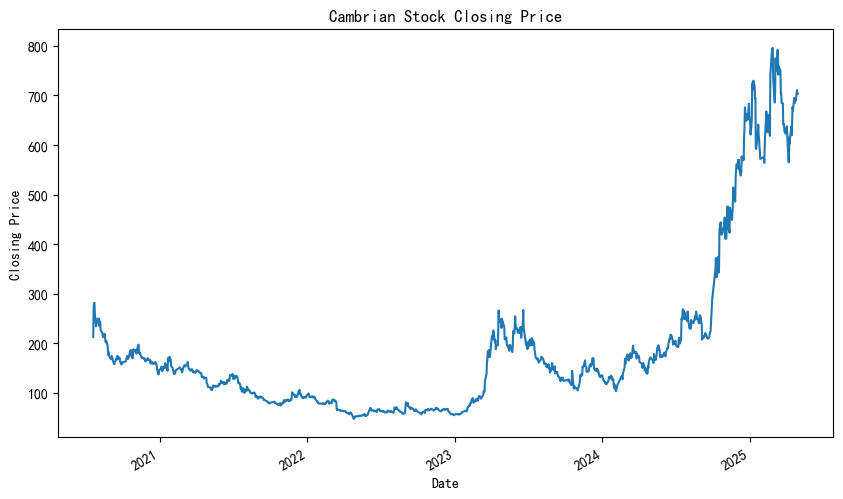

In [45]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 绘制收盘价时间序列图
plt.figure(figsize=(10, 6))
df_close.plot()
plt.title("Cambrian Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [46]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
# ——1. 屏蔽 KPSS 的 InterpolationWarning ——  
warnings.filterwarnings("ignore", category=InterpolationWarning)

# 使用ADF 和 KPSS相互验证
def adf_kpss_test(series, name="series"):
    """对给定序列做 ADF + KPSS 检验，并打印结果。"""
    # ADF
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series, autolag='AIC')
    print(f"\n—— {name} ——")
    print("ADF 检验：")
    print(f"  Statistic = {adf_stat:.4f}, p-value = {adf_p:.4f}")
    for level, crit in adf_crit.items():
        print(f"    {level} critical value = {crit:.4f}")
    print("  结论：", "平稳" if adf_p < 0.05 else "非平稳")

    # KPSS
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
    print("KPSS 检验：")
    print(f"  Statistic = {kpss_stat:.4f}, p-value = {kpss_p:.4f}")
    for level, crit in kpss_crit.items():
        print(f"    {level} critical value = {crit:.4f}")
    print("  结论：", "平稳" if kpss_p > 0.05 else "非平稳")

In [47]:
# ——2. 原始收盘价序列检验——
# 假设 df_close 已经是按交易日索引的收盘价Series
adf_kpss_test(df_close, "原始收盘价序列")


—— 原始收盘价序列 ——
ADF 检验：
  Statistic = 1.6873, p-value = 0.9981
    1% critical value = -3.4361
    5% critical value = -2.8641
    10% critical value = -2.5681
  结论： 非平稳
KPSS 检验：
  Statistic = 2.4153, p-value = 0.0100
    10% critical value = 0.3470
    5% critical value = 0.4630
    2.5% critical value = 0.5740
    1% critical value = 0.7390
  结论： 非平稳


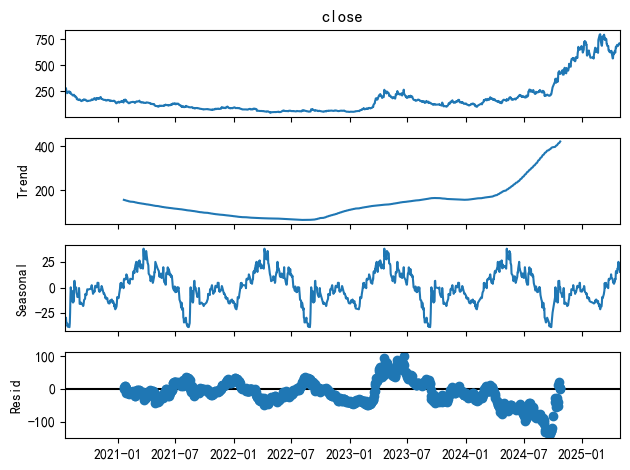

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 假设 df_close 是原始的、已清洗好的交易日收盘价序列
result = seasonal_decompose(df_close, model='additive', period=252)

# 绘图
result.plot()
plt.show()

In [49]:
# 季节性是否可忽略? 标准是什么？

In [50]:
df_diff = df_close.diff().dropna()
print(df_diff.head(3))

trade_date
2020-07-21    61.6
2020-07-22     7.0
2020-07-23     0.5
Name: close, dtype: float64


In [51]:
adf_kpss_test(df_diff, "一阶差分序列")


—— 一阶差分序列 ——
ADF 检验：
  Statistic = -8.5541, p-value = 0.0000
    1% critical value = -3.4361
    5% critical value = -2.8641
    10% critical value = -2.5681
  结论： 平稳
KPSS 检验：
  Statistic = 0.6306, p-value = 0.0199
    10% critical value = 0.3470
    5% critical value = 0.4630
    2.5% critical value = 0.5740
    1% critical value = 0.7390
  结论： 非平稳


In [52]:
# 进行KPSS进一步检验，防止过度差分

In [53]:
# KPSS 水平平稳（regression='c'）
stat_c, p_c, _, crit_c = kpss(df_diff, regression='c', nlags='auto')
print("KPSS(level) p-value =", p_c)

# KPSS 趋势平稳（regression='ct'）
stat_ct, p_ct, _, crit_ct = kpss(df_diff, regression='ct', nlags='auto')
print("KPSS(trend) p-value =", p_ct)

KPSS(level) p-value = 0.01985674816086362
KPSS(trend) p-value = 0.1


In [54]:
# 在 ARIMA 模型里加入趋势项不在进行差分              trend='t'
# KPSS(trend) 的 p-value = 0.10（>0.05） 表明在去除线性趋势之后，序列已经平稳，
# 也就是说它是“趋势平稳”（trend-stationary）而不是“差分平稳”（difference-stationary）
# 再做二阶差分有可能过度差分，反而引入负自相关。

In [55]:
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

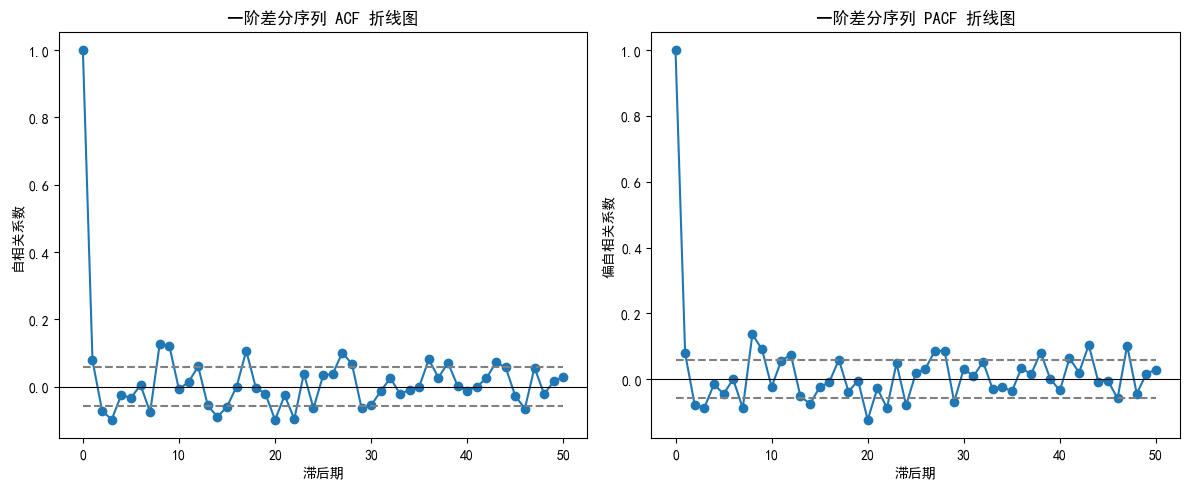

In [56]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']        # 指定黑体
plt.rcParams['axes.unicode_minus'] = False          # 解决负号 ‘-’ 显示成方块

# ACF/PACF 折线图
nlags = 50
acf_vals = acf(df_diff, nlags=nlags, fft=False)
pacf_vals = pacf(df_diff, nlags=nlags, method='ywm')
conf_int = 1.96 / np.sqrt(len(df_diff))

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.arange(nlags+1), acf_vals, marker='o', linestyle='-')
plt.hlines([conf_int, -conf_int], xmin=0, xmax=nlags, linestyles='--', colors='gray')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('一阶差分序列 ACF 折线图')
plt.xlabel('滞后期')
plt.ylabel('自相关系数')

plt.subplot(122)
plt.plot(np.arange(nlags+1), pacf_vals, marker='o', linestyle='-')
plt.hlines([conf_int, -conf_int], xmin=0, xmax=nlags, linestyles='--', colors='gray')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('一阶差分序列 PACF 折线图')
plt.xlabel('滞后期')
plt.ylabel('偏自相关系数')
plt.tight_layout()
plt.show()

In [57]:
# 差分后序列虽然去掉了趋势，但仍存在轻微的自相关结构，不是“白噪声”。

In [58]:
# 双检验均强烈拒绝“白噪声” 原假设，
# 说明一阶差分后序列仍有残余的线性自相关结构，这是做 ARIMA 建模的直接依据。

# 双检验强烈拒绝“白噪声”，说明双检验均强烈拒绝“白噪声” 原假设（也就是方差本身）也存在集群式自相关，
# 即典型的 ARCH 效应，需要用 GARCH 模型去刻画波动聚集性。

In [59]:
# 训练/测试集拆分
train_end = '2024-12-31'
df_train = df_close.loc[:train_end]
df_test  = df_close.loc['2025-01-01':]

In [60]:
import warnings
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# 屏蔽拟合中可能出现的警告
warnings.filterwarnings("ignore")

In [61]:
# 1. 超参数范围
p_list = range(0, 4)    # 自回归阶数 p
d = 1                   # 差分阶数 d
q_list = range(0, 4)    # 移动平均阶数 q

# 3. 网格搜索
records = []
for p in p_list:
    for q in q_list:
        try:
            # 实际上 trend = c 效果就是不如T因为我们在一阶差分的KPSS检验就已经得知有趋势 trend = t
            model = ARIMA(df_train, order=(p, d, q), trend= 't')
            res = model.fit()
            records.append({
                'p': p,
                'd': d,
                'q': q,
                'aic': res.aic,
                'bic': res.bic
            })
        except Exception:
            continue
# 4. 汇总结果并找出最优
df_res = pd.DataFrame(records)

best_by_aic = df_res.loc[df_res['aic'].idxmin()]
best_by_bic = df_res.loc[df_res['bic'].idxmin()]

In [62]:
print("\n—— AIC 排名 ——")
print(df_res.sort_values('aic').head(10).to_string(index=False))
print("\n—— BIC 排名 ——")
print(df_res.sort_values('bic').head(10).to_string(index=False))


—— AIC 排名 ——
 p  d  q         aic         bic
 3  1  1 7760.701702 7790.615553
 1  1  3 7762.428693 7792.342544
 3  1  2 7762.669283 7797.568776
 3  1  3 7763.307596 7803.192731
 2  1  2 7763.526585 7793.440436
 3  1  0 7764.948863 7789.877072
 2  1  3 7765.328620 7800.228112
 0  1  3 7766.759819 7791.688028
 2  1  1 7768.598366 7793.526575
 2  1  0 7768.992027 7788.934594

—— BIC 排名 ——
 p  d  q         aic         bic
 2  1  0 7768.992027 7788.934594
 0  1  0 7779.162771 7789.134054
 3  1  0 7764.948863 7789.877072
 3  1  1 7760.701702 7790.615553
 0  1  3 7766.759819 7791.688028
 0  1  2 7771.886886 7791.829453
 0  1  1 7777.114313 7792.071238
 1  1  3 7762.428693 7792.342544
 1  1  0 7777.879249 7792.836174
 2  1  2 7763.526585 7793.440436


In [63]:
# model基本效等效

In [64]:
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# 假定 df_res 是你之前跑 AIC/BIC 网格搜索时得到的 DataFrame，
# 包括 ['p','d','q','trend','aic','bic'] 列
# 如果你还没生成，可以先照上面示例生成 df_res

# 1. 只保留唯一的模型组合
unique_models = df_res[['p','d','q']].drop_duplicates().reset_index(drop=True)

records = []
for idx, row in unique_models.iterrows():
    p, d, q = int(row.p), int(row.d), int(row.q)
    try:
        # 2. 拟合 ARIMA
        model = ARIMA(df_train, order=(p, d, q), trend='t').fit()
        resid = model.resid
        resid = res.resid.dropna()      # 去掉任何NaN
        resid = resid.iloc[1:]
        # 3. 检验残差平方的自相关（判断 ARCH 效应）
        lb2 = acorr_ljungbox(resid**2, lags=[10], return_df=True)
        arch_pvalue = lb2['lb_pvalue'].iloc[0]
        
        # （可选）也可以用统计检验 het_arch：
        # _, arch_pvalue, _, _ = het_arch(resid)
        
        # 4. 预测并计算指标
        n_test = len(df_test)
        y_pred = model.forecast(steps=n_test)
        y_pred.index = df_test.index
        
        mae  = mean_absolute_error(df_test, y_pred)
        rmse = np.sqrt(mean_squared_error(df_test, y_pred))
        mape = mean_absolute_percentage_error(df_test, y_pred)
        dir_acc = (np.sign(df_test.diff().dropna()) == 
                   np.sign(y_pred.diff().dropna())).mean()
        
        records.append({
            'p': p,
            'd': d,
            'q': q,
            'aic': model.aic,
            'bic': model.bic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'DirAcc': dir_acc,
            'ARCH_pvalue': arch_pvalue
        })
    except Exception as e:
        print(f"模型 {(p,d,q,trend)} 跳过，原因：{e}")

# 5. 汇总结果
df_metrics = pd.DataFrame(records)

# 标记哪些模型需要后续 GARCH 拟合（ARCH_pvalue < 0.05）
df_metrics['need_GARCH'] = df_metrics['ARCH_pvalue'] < 0.05

# 按 RMSE 排序，展示前 10
print("按 RMSE 排名前 10:")
print(df_metrics.sort_values('RMSE').head(10))

# 如果还想看所有需要 GARCH 的
print("\n需要 GARCH 拟合的模型：")
print(df_metrics[df_metrics['need_GARCH']])


按 RMSE 排名前 10:
    p  d  q          aic          bic        MAE       RMSE      MAPE  \
11  2  1  3  7765.328620  7800.228112  50.857437  61.323285  0.075494   
10  2  1  2  7763.526585  7793.440436  50.863803  61.329112  0.075492   
15  3  1  3  7763.307596  7803.192731  50.903450  61.329668  0.075583   
14  3  1  2  7762.669283  7797.568776  50.925885  61.344878  0.075621   
13  3  1  1  7760.701702  7790.615553  50.927885  61.347426  0.075626   
12  3  1  0  7764.948863  7789.877072  50.854583  61.348052  0.075449   
7   1  1  3  7762.428693  7792.342544  50.967635  61.352842  0.075748   
9   2  1  1  7768.598366  7793.526575  50.871906  61.357234  0.075469   
6   1  1  2  7771.532403  7796.460612  50.904471  61.361178  0.075567   
3   0  1  3  7766.759819  7791.688028  50.857147  61.365836  0.075427   

      DirAcc   ARCH_pvalue  need_GARCH  
11  0.467532  1.418102e-72        True  
10  0.454545  1.418102e-72        True  
15  0.467532  1.418102e-72        True  
14  0.467532  1.4

In [65]:
# 在样本数据上都有差不多的拟合度，没必要过度追求“最小那一点点”，
# 而应该选择更简单（参数更少）的模型。

In [66]:
# 因为上边的KPSS趋势验证，我们需要添加trend t

In [67]:
# 选择最简单的model

In [68]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1. 拟合 ARIMA(2,1,3)
model = ARIMA(df_train, order=(2, 1, 3), trend='t')  # trend='t' 因为上边的KPSS趋势验证，我们需要添加trend t
res = model.fit()

In [69]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

def evaluate_arima(res, df_train, df_test):
    """
    修正版：使用 forecast() 而非 predict()，避免 KeyError。
    """
    # 1. 拟合摘要
    print(res.summary(), "\n")

    # 2. 残差诊断
    resid = res.resid
    resid = res.resid.dropna()      # 去掉任何NaN
    resid = resid.iloc[1:]          # 丢掉第一个残差

    plt.figure(figsize=(12,8))
    plt.subplot(221)
    plot_acf(resid, lags=40, ax=plt.gca(), title='Residuals ACF')
    plt.subplot(222)
    plot_pacf(resid, lags=40, ax=plt.gca(), title='Residuals PACF')
    plt.subplot(223)
    plt.hist(resid, bins=30, density=True)
    plt.title('Residual Histogram')
    plt.subplot(224)
    qqplot(resid, line='s', ax=plt.gca())
    plt.title('Residual Q–Q Plot')
    plt.tight_layout()
    plt.show()

    bp_lb = acorr_ljungbox(resid, lags=[10], boxpierce=True, return_df=True)
    bp_lb2 = acorr_ljungbox(resid**2, lags=[10], boxpierce=True, return_df=True)

    print("Ljung–Box 检验（残差序列）:")
    print(bp_lb[['lb_stat', 'lb_pvalue']])
    print("\nLjung–Box 检验（残差序列平方）:")
    print(bp_lb2[['lb_stat', 'lb_pvalue']])

    print("\nBox–Pierce 检验（残差序列）:")
    print(bp_lb[['bp_stat', 'bp_pvalue']])
    print("\nBox–Pierce 检验（残差序列平方）:")
    print(bp_lb2[['bp_stat', 'bp_pvalue']])

    # 3. 预测准确性：使用 forecast()
    n_test = len(df_test)
    y_pred = res.forecast(steps=n_test)  # 直接外推 n_test 步
    y_pred.index = df_test.index        # 对齐测试集索引

    # 3.1 指标计算
    mae  = mean_absolute_error(df_test, y_pred)
    rmse = np.sqrt(mean_squared_error(df_test, y_pred))
    mape = mean_absolute_percentage_error(df_test, y_pred)
    print("\nForecast Accuracy on Test Set:")
    print(f"  MAE : {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4%}\n")

    fc = res.get_forecast(steps=n_test)
    mean_fc = fc.predicted_mean
    mean_fc.index = df_test.index

    direction_true = np.sign(df_test.diff().dropna())
    direction_pred = np.sign(mean_fc.diff().dropna())
    dir_acc = (direction_true == direction_pred).mean()
    print(f"Directional Accuracy: {dir_acc:.2%}")

    p, d, q = res.model.order
    trend = res.model.trend
    plt.figure(figsize=(10, 5))
    plt.plot(df_test.index, df_test, label='Actual Close', linewidth=1.5)
    plt.plot(y_pred.index, y_pred, '--', label='Forecast Close', linewidth=1.5)
    plt.title(f"ARIMA({p},{d},{q}), trend='{trend}'  Rolling Forecast")
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1082
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3875.664
Date:                Wed, 07 May 2025   AIC                           7765.329
Time:                        15:52:03   BIC                           7800.228
Sample:                             0   HQIC                          7778.543
                               - 1082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4050      0.313      1.294      0.196      -0.208       1.018
ar.L1          0.6406      0.110      5.821      0.000       0.425       0.856
ar.L2         -0.6444      0.067     -9.651      0.0

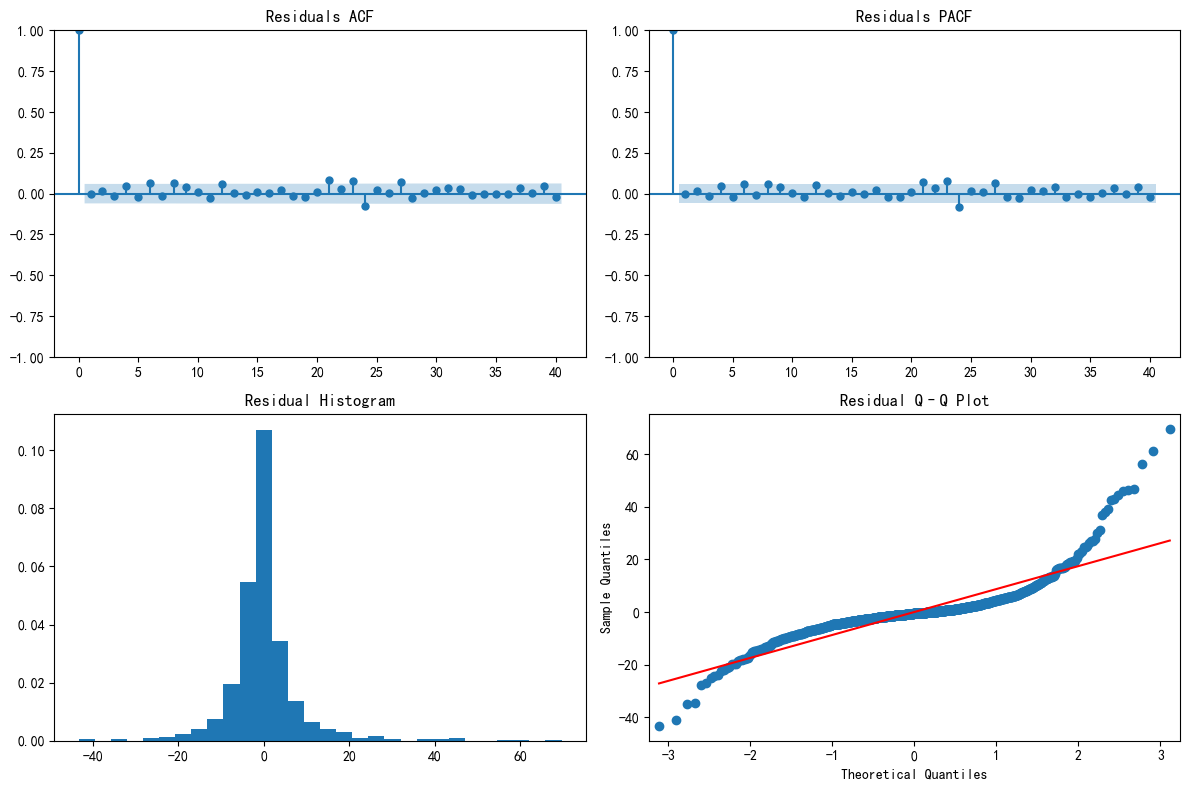

Ljung–Box 检验（残差序列）:
      lb_stat  lb_pvalue
10  13.867584   0.179118

Ljung–Box 检验（残差序列平方）:
       lb_stat     lb_pvalue
10  358.071443  7.710430e-71

Box–Pierce 检验（残差序列）:
      bp_stat  bp_pvalue
10  13.758056   0.184316

Box–Pierce 检验（残差序列平方）:
       bp_stat     bp_pvalue
10  355.497569  2.713483e-70

Forecast Accuracy on Test Set:
  MAE : 50.8574
  RMSE: 61.3233
  MAPE: 7.5494%

Directional Accuracy: 46.75%


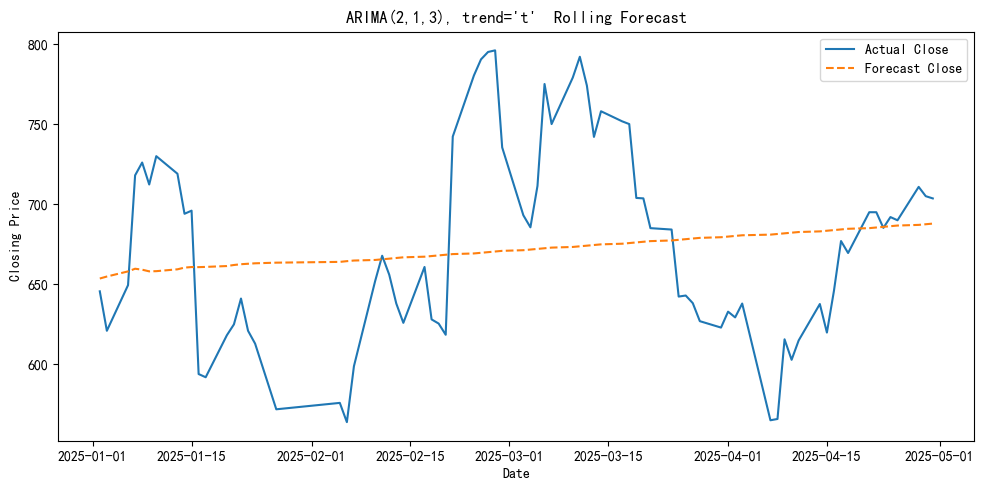

In [70]:
evaluate_arima(res, df_train, df_test)

In [71]:
# check outlier

In [72]:
import numpy as np
thresh = 3 * np.std(resid)
outliers = resid[np.abs(resid) > thresh]
print(outliers)

trade_date
2020-07-21    61.193865
2020-07-27   -27.225951
2023-04-19    26.954761
2023-04-20    42.425765
2023-05-26    28.077310
2023-06-20    27.012161
2023-06-21   -35.066331
2024-07-16    39.464774
2024-09-05   -34.687953
2024-09-30    46.561246
2024-10-08    56.421437
2024-10-09    26.871672
2024-10-14    38.281133
2024-10-15   -26.868532
2024-10-18    65.821291
2024-11-01   -43.757936
2024-11-08   -41.666904
2024-11-13    45.107123
2024-11-21    37.900899
2024-11-27    42.672775
2024-12-12    32.005772
2024-12-18    46.048078
2024-12-20    42.025579
2024-12-30    28.658247
2024-12-31   -26.902504
dtype: float64


In [73]:
# 效果非常之差
# 甚至不如抛硬币，说明我们的project存在重大问题
# 或者说我们用来评判的标准存在问题

In [74]:
# ── 0. 依赖 ────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_absolute_percentage_error)

# 假设 df_close 已在环境中，是 pd.Series，索引为 Datetime

# ── 1. 滚动预测函数（1 步预测，扩张式窗口）───────────────────────────────
def rolling_forecast(series, order, trend, start_train_end):
    train = series[:start_train_end].copy()
    test  = series[start_train_end:].copy()

    y_true, y_pred = [], []

    for date, actual in test.items():      # 逐日滚动
        model = ARIMA(train, order=order, trend=trend).fit()
        pred  = model.forecast(1).iloc[0]
        y_true.append(actual)
        y_pred.append(pred)
        train.loc[date] = actual           # 扩张式窗口

    y_true = pd.Series(y_true, index=test.index)
    y_pred = pd.Series(y_pred, index=test.index)
    rmse   = np.sqrt(mean_squared_error(y_true, y_pred))
    return y_true, y_pred, rmse

# ── 2. 候选模型列表 ───────────────────────────────────────────────────────
model_configs = [
    {'p':2,'d':1,'q':3,'trend':'t'},
    {'p':2,'d':1,'q':2,'trend':'t'},
    {'p':3,'d':1,'q':3,'trend':'t'},
    {'p':3,'d':1,'q':2,'trend':'t'},
    {'p':3,'d':1,'q':1,'trend':'t'},
    {'p':3,'d':1,'q':0,'trend':'t'},
    {'p':1,'d':1,'q':3,'trend':'t'},
    {'p':2,'d':1,'q':1,'trend':'t'},
    {'p':1,'d':1,'q':2,'trend':'t'},
    {'p':0,'d':1,'q':3,'trend':'t'},
]

# ── 3. 逐模型滚动预测并评估 ───────────────────────────────────────────────
results = []
for cfg in model_configs:
    order = (cfg['p'], cfg['d'], cfg['q'])
    trend = cfg['trend']
    _, _, rmse = rolling_forecast(df_close, order, trend, '2024-12-31')
    results.append({**cfg, 'RMSE': rmse})

df_results = (pd.DataFrame(results)
                .sort_values('RMSE')
                .reset_index(drop=True))
print("\n滚动预测评估结果（按 RMSE 升序）：")
print(df_results)


滚动预测评估结果（按 RMSE 升序）：
   p  d  q trend       RMSE
0  1  1  2     t  30.703583
1  2  1  1     t  30.738120
2  0  1  3     t  30.757759
3  3  1  0     t  30.808496
4  1  1  3     t  30.894165
5  3  1  1     t  31.072891
6  3  1  2     t  31.220718
7  2  1  3     t  31.276185
8  3  1  3     t  31.490010
9  2  1  2     t  32.218934



=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1082
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3880.766
Date:                Wed, 07 May 2025   AIC                           7771.532
Time:                        16:02:50   BIC                           7796.461
Sample:                             0   HQIC                          7780.971
                               - 1082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4066      0.319      1.275      0.202      -0.218       1.032
ar.L1          0.2794      0.193      1.447      0.148      -0.099       0.658
ma.L1         -0.2255  

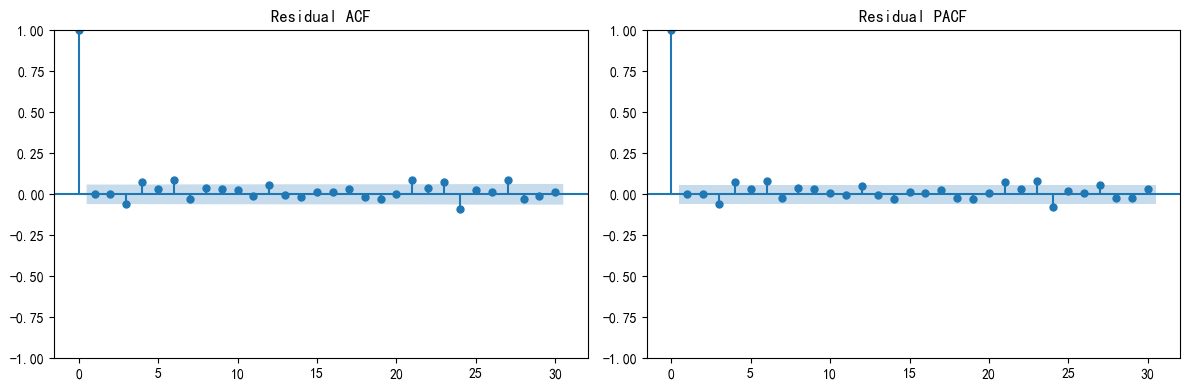

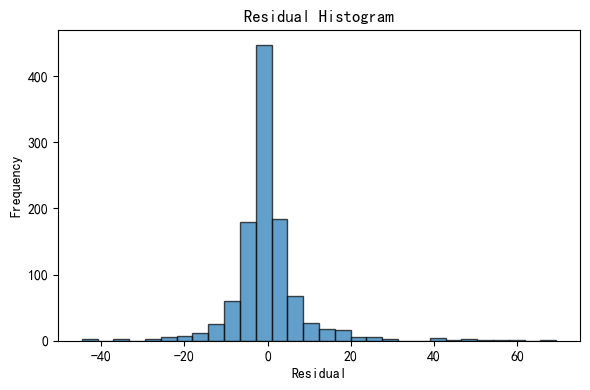

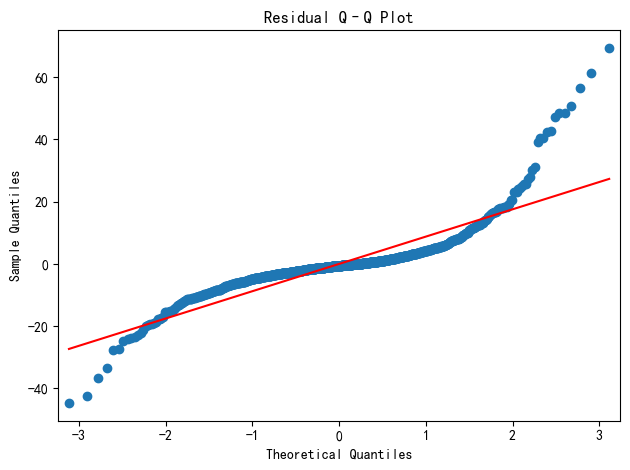


Ljung–Box test (lags 10 & 20):
      lb_stat  lb_pvalue
10  23.391914   0.009389
20  30.585305   0.060909

Breusch–Pagan test:
  BP statistic = 152.4966,  p‑value = 0.0000

最佳模型 ARIMA(1, 1, 2), trend='t' 在价格上的预测性能：
  MAE  = 21.3931
  RMSE = 30.7036
  MAPE = 3.20%
  Directional Accuracy = 44.87%


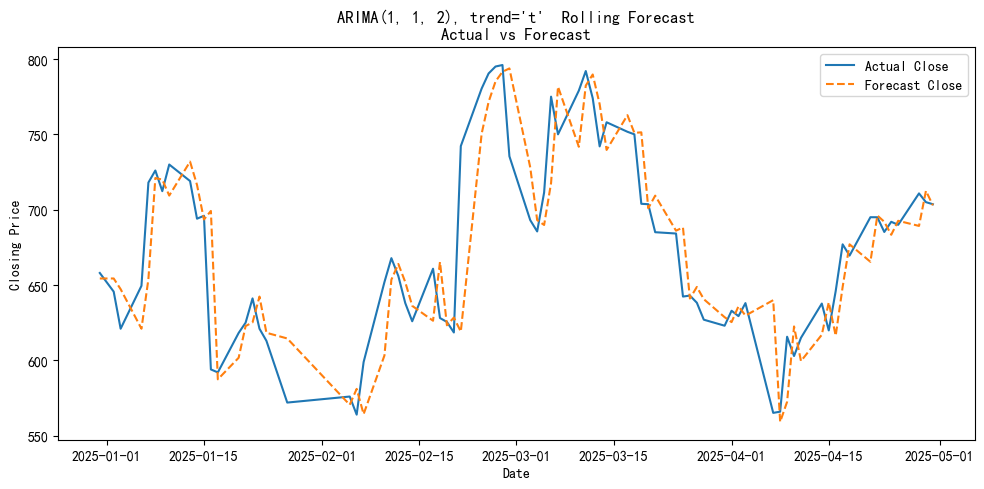

In [75]:
# ── 4. 选取最佳模型并获取预测 ─────────────────────────────────────────────
best_cfg = df_results.iloc[0]
order = (int(best_cfg.p), int(best_cfg.d), int(best_cfg.q))
trend = best_cfg.trend

y_true_price, y_pred_price, _ = rolling_forecast(
    df_close, order, trend, '2024-12-31'
)

# ── 5. 最优模型摘要 & 残差诊断 ───────────────────────────────────────────
# 5‑A 重新在「训练集」上拟合一次以获取完整摘要
train_series = df_close[:'2024-12-31']
res = ARIMA(train_series, order=order, trend=trend).fit()

print("\n=== ARIMA Model Summary ===")
print(res.summary())                       # <‑‑ 这是你要的 summary

# 5‑B 取残差并清洗
resid = res.resid.dropna().iloc[1:]        # 首个残差 often NaN，且差分后再丢掉第一项

# 5‑C ACF / PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(resid, ax=axes[0], lags=30, title="Residual ACF")
plot_pacf(resid, ax=axes[1], lags=30, title="Residual PACF", method="ywm")
plt.tight_layout()
plt.show()

# 5‑D 残差直方图
plt.figure(figsize=(6, 4))
plt.hist(resid, bins=30, edgecolor='k', alpha=0.7)
plt.title("Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5‑E Q–Q plot
import statsmodels.api as sm
sm.qqplot(resid, line='s')
plt.title("Residual Q–Q Plot")
plt.tight_layout()
plt.show()

# 5‑F Ljung‑Box
lb_test = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
print("\nLjung–Box test (lags 10 & 20):")
print(lb_test)

fitted = res.fittedvalues.loc[resid.index]
exog_bp = sm.add_constant(fitted)
bp_stat, bp_pvalue, *_ = het_breuschpagan(resid, exog_bp)
print(f"\nBreusch–Pagan test:\n  BP statistic = {bp_stat:.4f},  p‑value = {bp_pvalue:.4f}")

# ── 6. 精度指标 ─────────────────────────────────────────────────────────
mae   = mean_absolute_error(y_true_price, y_pred_price)
rmse  = np.sqrt(mean_squared_error(y_true_price, y_pred_price))
mape  = mean_absolute_percentage_error(y_true_price, y_pred_price)
dacc  = (np.sign(y_true_price.diff().dropna()) ==
         np.sign(y_pred_price.diff().dropna())).mean()

print(f"\n最佳模型 ARIMA{order}, trend='{trend}' 在价格上的预测性能：")
print(f"  MAE  = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"  MAPE = {mape:.2%}")
print(f"  Directional Accuracy = {dacc:.2%}")

# ── 7. 实际值 vs 预测值 可视化 ───────────────────────────────────────────
plt.figure(figsize=(10, 5))
plt.plot(y_true_price.index, y_true_price, label='Actual Close', linewidth=1.5)
plt.plot(y_pred_price.index, y_pred_price, '--', label='Forecast Close', linewidth=1.5)
plt.title(f"ARIMA{order}, trend='{trend}'  Rolling Forecast\nActual vs Forecast")
plt.xlabel('Date');  plt.ylabel('Closing Price')
plt.legend();  plt.tight_layout();  plt.show()


In [80]:
y_pred_price - y_true_price

trade_date
2024-12-31    -3.655658
2025-01-02     8.724342
2025-01-03    26.253859
2025-01-06   -28.470808
2025-01-07   -64.085644
                ...    
2025-04-24    -8.611240
2025-04-25     2.664006
2025-04-28   -21.582444
2025-04-29     7.506409
2025-04-30    -0.731982
Length: 79, dtype: float64

In [77]:
# 下面是ARIMA + GARCH + 滚动窗口拟合


ARIMA(1, 1, 2) → GARCH(1,1)  Rolling Forecast (Test 2025)
MAE  = 33.13
RMSE = 42.62
MAPE = 4.99%
Directional Accuracy = 47.37%


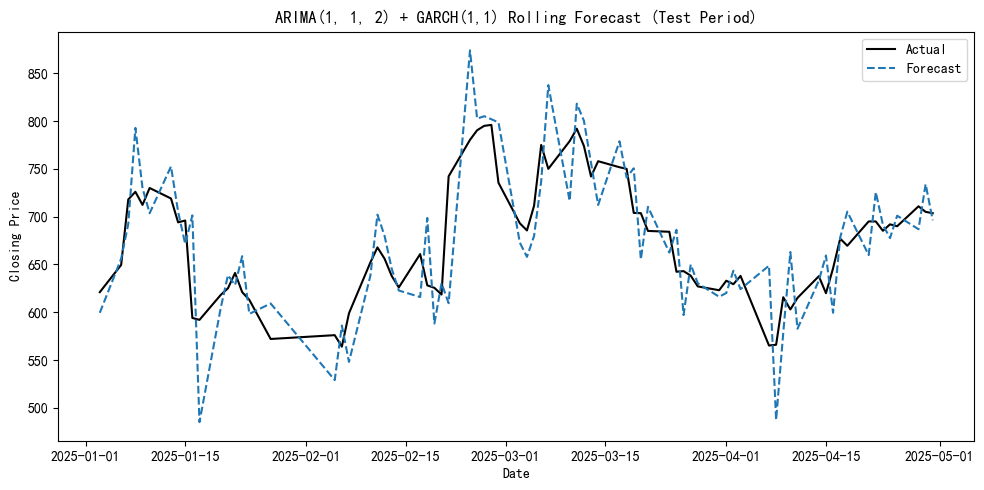

In [84]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# ——————————————————————————
# 0. 训练 / 测试拆分
# ——————————————————————————
train_end = '2024-12-31'
df_train  = df_close.loc[:train_end]
df_test   = df_close.loc['2025-01-01':]

# ——————————————————————————
# 1. ARIMA(1,1,2)  初次拟合（无趋势）
# ——————————————————————————
order = (1, 1, 2)
ar_res = ARIMA(df_train, order=order, trend='t').fit()

# ——————————————————————————
# 2. GARCH(1,1)  在残差上拟合一次
# ——————————————————————————
resid_init = ar_res.resid.dropna().iloc[1:]
gmod  = arch_model(resid_init, mean='Zero', vol='Garch', p=1, q=1)
g_res = gmod.fit(disp='off')
ω, α1, β1 = g_res.params['omega'], g_res.params['alpha[1]'], g_res.params['beta[1]']

# ——————————————————————————
# 3. 初始化递推状态
# ——————————————————————————
last_price  = df_train.iloc[-1]
last_resid  = resid_init.iloc[-1]
last_sigma2 = g_res.conditional_volatility.iloc[-1]**2

# —— 热身：把测试首日真实差分 append 到 ARIMA ——
first_price  = df_test.iloc[0]
first_diff   = first_price - last_price
ar_res = ar_res.append([first_diff], refit=False)


last_price  = first_price
last_resid  = 0.0                       # 视作命中
last_sigma2 = ω / (1 - α1 - β1)         # 长期波动

# ——————————————————————————
# 4. 一步滚动预测
# ——————————————————————————
true_p, pred_p, pred_v = [], [], []

for actual in df_test.iloc[1:]:
    # 4.1 均值预测
    d_pred     = float(ar_res.forecast(1))
    price_pred = last_price + d_pred

    # 4.2 波动预测
    sigma2_pred = ω + α1*last_resid**2 + β1*last_sigma2
    vol_pred    = np.sqrt(sigma2_pred)

    # 保存
    true_p.append(actual)
    pred_p.append(price_pred)
    pred_v.append(vol_pred)

    # 4.3 更新状态
    diff_act  = actual - last_price
    ar_res    = ar_res.append([diff_act], refit=False)
    last_resid, last_sigma2, last_price = diff_act - d_pred, sigma2_pred, actual

idx   = df_test.index[1:]
true  = pd.Series(true_p, index=idx)
pred  = pd.Series(pred_p, index=idx)
vol   = pd.Series(pred_v, index=idx)

# ——————————————————————————
# 5. 评估
# ——————————————————————————
mae  = mean_absolute_error(true, pred)
rmse = np.sqrt(mean_squared_error(true, pred))
mape = mean_absolute_percentage_error(true, pred)*100
dir_acc = (np.sign(np.diff(pred)) == np.sign(np.diff(true))).mean()*100

print(f"\nARIMA{order} → GARCH(1,1)  Rolling Forecast (Test 2025)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")
print(f"Directional Accuracy = {dir_acc:.2f}%")

# ——————————————————————————
# 6. 仅测试期可视化
# ——————————————————————————
plt.figure(figsize=(10,5))
plt.plot(true, label='Actual', color='black')
plt.plot(pred, '--', label='Forecast', color='#1f77b4')
plt.legend()
plt.title(f"ARIMA{order} + GARCH(1,1) Rolling Forecast (Test Period)")
plt.xlabel("Date"); plt.ylabel("Closing Price")
plt.tight_layout(); plt.show()


In [ ]:
alpha + beta < 1 将近0.9   omega   0.01一个很低的数   alpha beta都是大于0